In [1]:
import torch
import pandas as pd
import random
from epifit.network_generation import generate_random_network
from epifit.graphing_utils import *
from matplotlib import pyplot as plt
import epifit2
import networkx as nx
from tqdm import tqdm

device = "cuda" if torch.cuda.is_available() else "cpu"



In [2]:
def sim(timeHorizon, model:epifit2.get_ER_random_contact):
  populationNumber= []
  populationExpectation= []
  for i in range(timeHorizon):
    populationNumberi, populationExpectationi= model()
    populationNumber.append(populationNumberi)
    populationExpectation.append(populationExpectationi)
  populationNumber = torch.stack(populationNumber)
  populationExpectation = torch.stack(populationExpectation)

  return populationNumber, populationExpectation

In [32]:
n= 4000
avgDegree= 5
timeHorizon= 40
contact=epifit2.get_ER_random_contact(n, avgDegree)
contact = contact.requires_grad_(True)
realData =None

with torch.no_grad():
    ps= torch.tensor([[0, 0.2, 0, 0],
                    [0, 0, 0.99, 0],
                    [0, 0, 0, 0.1],
                    [0.01, 0, 0, 0]], device=device)
    population= epifit2.population(n, device)
    model= epifit2.EPI_dense(contact, ps, population, device)
    realData, _ =sim(timeHorizon, model)


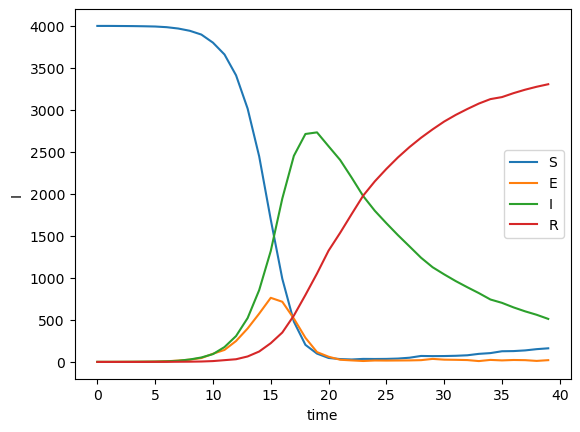

In [33]:
populationNumberPlot= realData.cpu().detach()
plt.plot(populationNumberPlot, label=['S', 'E', 'I', 'R'])
plt.xlabel("time")
plt.ylabel("I")
plt.legend()

In [75]:
realData.requires_grad_(True)
psFit= torch.tensor([[0, 0, 0, 0],
                     [0, 0, 0.0, 0],
                     [0, 0, 0, 0.0],
                     [0.0, 0, 0, 0]], device=device)
cc= torch.tensor([[0, 1, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1],
                    [1, 0, 0, 0]], device=device)
populationFit= epifit2.population(n, device)
modelFit= epifit2.EPI_dense(contact, psFit, populationFit, device, train=True, cc=cc, recursive=False)
lossFn = torch.nn.MSELoss(reduction='sum')
optimizer = torch.optim.Adam(modelFit.parameters(), lr=3e-1)

In [79]:
fitPinfs=[]
#1. choose a better optimiser
#2. bigmodel learn intrinsic, gradient easy model !!!
#3. adaptive constraint?
#4. GAN ?
optimizer = torch.optim.Adam(modelFit.parameters(), lr=3e-1)
for i in tqdm(range(100)):
    optimizer.zero_grad()
    fitPinfs.append(modelFit.get_psMatrix())
    populationFit= epifit2.population(n, device)
    modelFit.reset_population(populationFit)
    fitPopulation, expectation = sim(timeHorizon, modelFit)
    loss= lossFn(expectation, realData)
    #loss= lossFn(expectation[:, 2], realData[:, 2])
    loss.backward(retain_graph=True)
    optimizer.step()
print(modelFit.get_psMatrix())

100%|██████████| 100/100 [00:07<00:00, 13.56it/s]

tensor([[0.0000, 0.1380, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.9980, 0.0000],
        [0.0000, 0.0000, 0.0000, 0.0919],
        [0.0063, 0.0000, 0.0000, 0.0000]], device='cuda:0',
       grad_fn=<MulBackward0>)


In [64]:
print(modelFit.get_psMatrix())

tensor([[0.0000e+00, 1.5083e-02, 0.0000e+00, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 9.9583e-01, 0.0000e+00],
        [0.0000e+00, 0.0000e+00, 0.0000e+00, 2.9756e-01],
        [2.8673e-05, 0.0000e+00, 0.0000e+00, 0.0000e+00]], device='cuda:0',
       grad_fn=<MulBackward0>)


In [80]:
def print_model_parameters(model):
    for name, parameter in model.named_parameters():
        print('name           : {}'.format(name))
        print('parameter      : {}'.format(parameter))
        print('learnable      : {}'.format(parameter.requires_grad))
        print('parameter.shape: {}'.format(parameter.shape))
        print('parameter.grad: {}'.format(parameter.grad))
        print('---------------------------------')
print_model_parameters(modelFit)

name           : _psMatrix
parameter      : Parameter containing:
tensor([[ 0.0000, -1.8323,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  6.1962,  0.0000],
        [ 0.0000,  0.0000,  0.0000, -2.2906],
        [-5.0626,  0.0000,  0.0000,  0.0000]], device='cuda:0',
       requires_grad=True)
learnable      : True
parameter.shape: torch.Size([4, 4])
parameter.grad: tensor([[       0.0000, -4107996.5000,        0.0000,        0.0000],
        [       0.0000,        0.0000,    -6282.2163,        0.0000],
        [       0.0000,        0.0000,        0.0000, -4227054.0000],
        [  202616.2188,        0.0000,        0.0000,        0.0000]],
       device='cuda:0')
---------------------------------


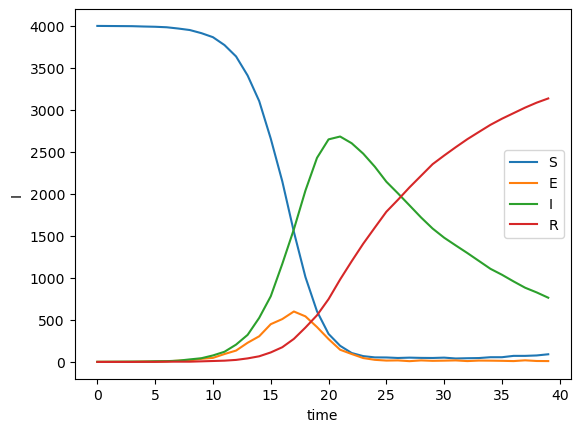

In [81]:
populationNumberPlot2= fitPopulation.cpu().detach()
plt.plot(populationNumberPlot2, label=['S', 'E', 'I', 'R'])
plt.xlabel("time")
plt.ylabel("I")
plt.legend()